In [5]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from efficientnet_pytorch import EfficientNet
import random
import time

### Load data

In [ ]:
!wget --random-wait -i ../data/georges.csv -P ../data/images/georges
!wget --random-wait -i ../data/non_georges.csv -P ../data/images/non_georges

#### Remove dublicates

In [ ]:
!rm ../data/images/*/*.1
!rm ../data/images/*/*.2
!rm ../data/images/*/*.3

#### Visualize a few images

In [ ]:
fig = plt.figure(figsize=(16, 17))
axes = []
path = '../data/images/georges'
for i, img_name in zip(np.arange(1, 21), os.listdir(path)[:20]):
    axes.append(fig.add_subplot(4, 5, i))
    subplot_title = ('Image' + str(i))
    axes[-1].set_title(subplot_title) 
    img_path = os.path.join(path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [ ]:
fig = plt.figure(figsize=(16, 17))
axes = []
path = '../data/images/non_georges'
for i, img_name in zip(np.arange(1, 21), os.listdir(path)[:20]):
    axes.append(fig.add_subplot(4, 5, i))
    subplot_title = ('Image' + str(i))
    axes[-1].set_title(subplot_title) 
    img_path = os.path.join(path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

### Define training parameters

In [37]:
params = {
    'model': 'efficientnet-b1',
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'lr': 0.0005,
    'batch_size': 100,
    'num_workers': 8,
    'num_epochs': 15,
    'train_size': 0.7,
    'feature_extract': False,
    'num_classes': 2,
    'input_size': 240,
    'momentum': 0.9,
    'patience': 3
}

In [38]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### Define and initialize model

Pretrained Resnet-50 + 1 extra fully connected layer. I freeze layers 1-6 in the total 10 layers of Resnet50. 



In [39]:
model = EfficientNet.from_pretrained(params['model'])

Loaded pretrained weights for efficientnet-b1


In [40]:
num_ftrs = model._fc.in_features
linear_layers = nn.Sequential(
                nn.BatchNorm1d(num_features=num_ftrs),    
                nn.Linear(num_ftrs, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(0.6),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.BatchNorm1d(num_features=128),
                nn.Dropout(0.6),
                nn.Linear(128, 10),
            )
model._fc = linear_layers

for param in model.parameters():
    param.require_grad = False

for param in model._fc.parameters():
    param.require_grad = True

model = model.to(params['device'])

In [ ]:
print(model)

### Setup transforms, datasets, and dataloaders

In [42]:
class GeorgeVsNonGeorgeDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == 'georges':
            label = 1
        else:
            label = 0
        if self.transform is not None:
            image = self.transform(image=image)['image']
        return image, label

In [43]:
root_directory = '../data/images'

geo_directory = os.path.join(root_directory, 'georges')
nongeo_directory = os.path.join(root_directory, 'non_georges')

geo_images_paths = sorted([os.path.join(geo_directory, f) for f in os.listdir(geo_directory)])
nongeo_images_paths = sorted([os.path.join(nongeo_directory, f) for f in os.listdir(nongeo_directory)])
images_paths = [*geo_images_paths, *nongeo_images_paths]

num_imgs = len(images_paths)
indices = list(range(num_imgs))
class_names = ['non_georges', 'georges']

np.random.shuffle(images_paths)

split = int(params['train_size'] * num_imgs)
split2 = int((split + num_imgs) / 2)
train_paths, val_paths, test_paths = images_paths[:split], images_paths[split:split2], images_paths[split2:]

In [44]:
train_trans = A.Compose(
    [
        A.SmallestMaxSize(max_size=params['input_size'] + 5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=params['input_size'], width=params['input_size']),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_trans = A.Compose(
    [
        A.SmallestMaxSize(max_size=params['input_size'] + 5),
        A.CenterCrop(height=params['input_size'], width=params['input_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

train_data = GeorgeVsNonGeorgeDataset(images_filepaths=train_paths, transform=train_trans)
val_data = GeorgeVsNonGeorgeDataset(images_filepaths=val_paths, transform=val_trans)
test_data = GeorgeVsNonGeorgeDataset(images_filepaths=test_paths, transform=val_trans)

dataloaders_dict = {'train' : DataLoader(
    train_data, batch_size=params['batch_size'], shuffle=True, num_workers=params['num_workers']
),
                    'val': DataLoader(
    val_data, batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers']
),
                    'test': DataLoader(
    test_data, batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers']
)
                   }

### Create the optimizer and criterion

In [45]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(model.parameters(), lr=params['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=1, cooldown=1)

In [46]:
criterion = nn.CrossEntropyLoss()

### Train and evaluate

In [47]:
def train_model(model, dataloaders, criterion, optimizer, lr_scheduler, num_epochs=10):
    since = time.time()

    history = {
        'train_acc': [],
        'train_loss': [],
        'val_acc': [],
        'val_loss': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(params['device'])
                labels = labels.to(params['device'])

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                history['train_acc'].append(epoch_acc)
                history['train_loss'].append(epoch_loss)
            if phase == 'val':
                history['val_acc'].append(epoch_acc)
                history['val_loss'].append(epoch_loss)
        
        lr_scheduler.step(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [48]:
def visualize_images(model, num_images=6):
    mean = np.array([0.485, 0.456, 0.406])
    std =  np.array([0.229, 0.224, 0.225])
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(16, 17))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['test']):
            inputs = inputs.to(params['device'])
            labels = labels.to(params['device'])

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, true label: {class_names[labels[j]]}')
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0)) * std + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
def build_val_curves(hist):
    epochs = np.arange(1, params['num_epochs'] + 1)
    plt.figure()
    plt.plot(epochs, hist['train_acc'], label='train')
    plt.plot(epochs, hist['val_acc'], label='validation')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('model accuracy')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(epochs, hist['train_loss'], label='train')
    plt.plot(epochs, hist['val_loss'], label='validation')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('model loss')
    plt.title('loss curves')
    plt.legend()
    plt.show()

In [49]:
model, hist = train_model(model, dataloaders_dict, criterion, optimizer,
                          scheduler, num_epochs=params['num_epochs']
                         )

Epoch 1/15
----------
train Loss: 0.5338 Acc: 0.7270
val Loss: 0.7217 Acc: 0.7287

Epoch 2/15
----------
train Loss: 0.2870 Acc: 0.8854
val Loss: 0.3208 Acc: 0.8760

Epoch 3/15
----------
train Loss: 0.1814 Acc: 0.9328
val Loss: 0.2714 Acc: 0.9006

Epoch 4/15
----------
train Loss: 0.1280 Acc: 0.9534
val Loss: 0.2256 Acc: 0.9123

Epoch 5/15
----------
train Loss: 0.1054 Acc: 0.9654
val Loss: 0.2112 Acc: 0.9170

Epoch 6/15
----------
train Loss: 0.1003 Acc: 0.9672
val Loss: 0.2002 Acc: 0.9275

Epoch 7/15
----------
train Loss: 0.0943 Acc: 0.9694
val Loss: 0.1919 Acc: 0.9298

Epoch 8/15
----------
train Loss: 0.0962 Acc: 0.9697
val Loss: 0.1852 Acc: 0.9380

Epoch 9/15
----------
train Loss: 0.0932 Acc: 0.9697
val Loss: 0.1845 Acc: 0.9357

Epoch 10/15
----------
train Loss: 0.0999 Acc: 0.9662
val Loss: 0.1816 Acc: 0.9357

Epoch 11/15
----------
train Loss: 0.0868 Acc: 0.9707
val Loss: 0.1813 Acc: 0.9357

Epoch 12/15
----------
train Loss: 0.0892 Acc: 0.9707
val Loss: 0.1798 Acc: 0.9368

E

### Predict labels and visualize curves

In [50]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders_dict['test']:
        inputs, labels = data
        inputs = inputs.to(params['device'])
        labels = labels.to(params['device'])
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct / total}')

Accuracy of the network on test images: 93.80841121495327


In [ ]:
visualize_images(model, 12)

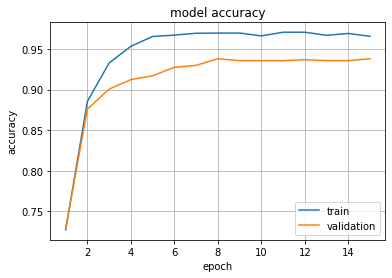

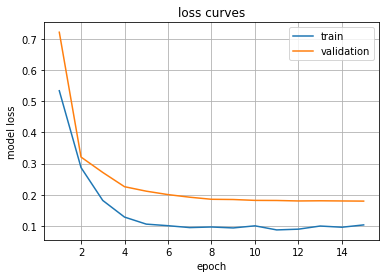

In [52]:
build_val_curves(hist)

In [53]:
torch.save(model.state_dict(), '../models/efficient-net-v1.pt')